- 데이터 준비
  - google drive 마운트
  - 파일 카피
  - 파일 압축 풀기
- 모델
  - 전이학습 템플릿 복사해오기
  - 데이터 폴더 이름 변경
  - 카테고리 갯수 변경


# 데이터


## google drive 마운트

In [1]:
from google.colab import drive 
drive.mount('/content/mnt')

Mounted at /content/mnt


## 파일 카피

In [2]:
!cp /content/mnt/MyDrive/cau_temp/data.zip ./

In [3]:
!ls -al

total 121780
drwxr-xr-x 1 root root      4096 Aug 26 05:41 .
drwxr-xr-x 1 root root      4096 Aug 26 05:39 ..
drwxr-xr-x 4 root root      4096 Aug 13 13:34 .config
-rw------- 1 root root 124677320 Aug 26 05:41 data.zip
drwx------ 6 root root      4096 Aug 26 05:41 mnt
drwxr-xr-x 1 root root      4096 Aug 13 13:35 sample_data


## 압축 풀기

In [4]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/test/
   creating: data/train/
   creating: data/test/advanced/
   creating: data/test/early/
  inflating: data/test/.DS_Store     
  inflating: __MACOSX/data/test/._.DS_Store  
   creating: data/test/normal/
   creating: data/train/advanced/
   creating: data/train/early/
  inflating: data/train/.DS_Store    
  inflating: __MACOSX/data/train/._.DS_Store  
   creating: data/train/normal/
  inflating: data/test/advanced/412.png  
  inflating: __MACOSX/data/test/advanced/._412.png  
  inflating: data/test/advanced/374.png  
  inflating: __MACOSX/data/test/advanced/._374.png  
  inflating: data/test/advanced/406.png  
  inflating: __MACOSX/data/test/advanced/._406.png  
  inflating: data/test/advanced/407.png  
  inflating: __MACOSX/data/test/advanced/._407.png  
  inflating: data/test/advanced/413.png  
  inflating: __MACOSX/data/test/advanced/._413.png  

In [5]:
!ls -al

total 121788
drwxr-xr-x 1 root root      4096 Aug 26 05:41 .
drwxr-xr-x 1 root root      4096 Aug 26 05:39 ..
drwxr-xr-x 4 root root      4096 Aug 13 13:34 .config
drwxr-xr-x 4 root root      4096 Aug 25 07:32 data
-rw------- 1 root root 124677320 Aug 26 05:41 data.zip
drwxr-xr-x 3 root root      4096 Aug 26 05:41 __MACOSX
drwx------ 6 root root      4096 Aug 26 05:41 mnt
drwxr-xr-x 1 root root      4096 Aug 13 13:35 sample_data


압축을 풀었을 때 data 폴더가 아닌 train, test 폴더가 보이는 경우 다음을 실행

```
!mkdir data
!mv train data/
!mv test data/
```

## 파일 갯수 확인

In [6]:
!ls -al data/train/normal/*.png | wc
!ls -al data/train/early/*.png | wc
!ls -al data/train/advanced/*.png | wc
!ls -al data/test/normal/*.png | wc
!ls -al data/test/early/*.png | wc
!ls -al data/test/advanced/*.png | wc

    630    5670   43362
    231    2079   15600
    373    3357   26375
    158    1422   10744
     58     522    3828
     94     846    6486


# 모델 학습

## 템플릿 그대로 적용

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 7, 7, 1408)        7768569   
_________________________________________________________________
flatten_1 (Flatten)          (None, 68992)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               17662208  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 25,432,572
Trainable params: 17,663,491
Non-trainable params: 7,769,081
_________________________________________________________________
Found 1234 images belonging to 3 classes.
Found 310 images belonging to 3 classes.
Epoch 1/10
19/19 

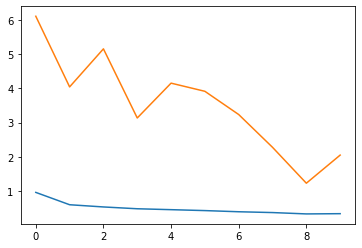

4/4 [==============================] - 1s 263ms/step - loss: 2.0487 - acc: 0.5000
loss= 2.0487143993377686
acc= 0.5


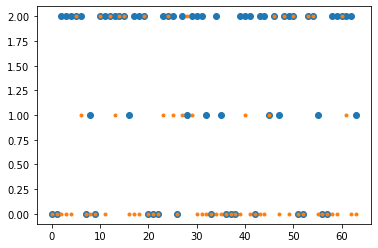

label category index = 0.0
predicted category index = 0
predicted category name = advanced


In [8]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))  # <-----------------------------------

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "data/train",  # <-----------------------------------
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "data/test",  # <-----------------------------------
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/BATCH_SIZE,  
      validation_steps=test_data_generator.samples/BATCH_SIZE,      
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/BATCH_SIZE
)
print("loss=", loss)
print("acc=", acc)



test_x, test_y = next(iter(test_data_generator))
y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", test_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


## batch size 찾기

In [20]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

# BATCH_SIZE = 64
BATCH_SIZE = 64*4  # <-----------------------------------

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "data/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "data/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/BATCH_SIZE,  
      validation_steps=test_data_generator.samples/BATCH_SIZE,      
      # epochs=10
      epochs=2
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/BATCH_SIZE
)
print("loss=", loss)
print("acc=", acc)



test_x, test_y = next(iter(test_data_generator))
y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", test_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 7, 7, 1408)        7768569   
_________________________________________________________________
flatten_11 (Flatten)         (None, 68992)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               17662208  
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 771       
Total params: 25,432,572
Trainable params: 17,663,491
Non-trainable params: 7,769,081
_________________________________________________________________
Found 1234 images belonging to 3 classes.
Found 310 images belonging to 3 classes.
Epoch 1/2
3/2 [=

TypeError: ignored

## 모델 사이즈 줄이기

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 7, 7, 1408)        7768569   
_________________________________________________________________
flatten_12 (Flatten)         (None, 68992)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2207776   
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 99        
Total params: 9,976,572
Trainable params: 2,207,939
Non-trainable params: 7,768,633
_________________________________________________________________
Found 1234 images belonging to 3 classes.
Found 310 images belonging to 3 classes.
Epoch 1/10
4/4 [==

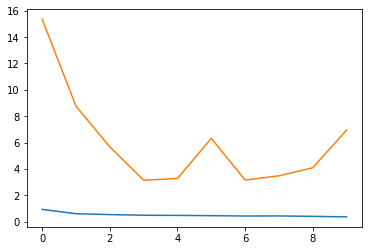

1/1 [==============================] - 1s 439ms/step - loss: 6.9499 - acc: 0.3097             
loss= 6.949938774108887
acc= 0.3096774220466614


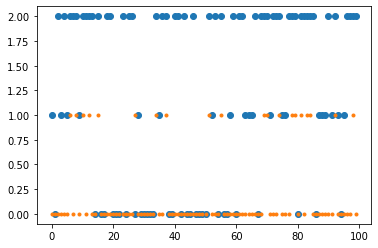

label category index = 1.0
predicted category index = 0
predicted category name = advanced


In [21]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(Flatten())
# model.add(Dense(256, activation='relu'))
model.add(Dense(32, activation='relu'))  # <-----------------------------------
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

# BATCH_SIZE = 64
BATCH_SIZE = 64*4

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "data/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "data/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/BATCH_SIZE,  
      validation_steps=test_data_generator.samples/BATCH_SIZE,      
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/BATCH_SIZE
)
print("loss=", loss)
print("acc=", acc)



test_x, test_y = next(iter(test_data_generator))
y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", test_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


# 성능 개선

## 카테고리 비율?

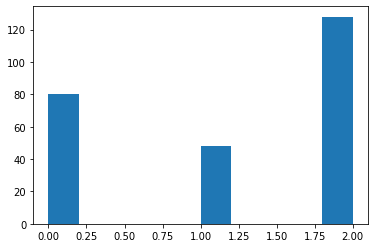

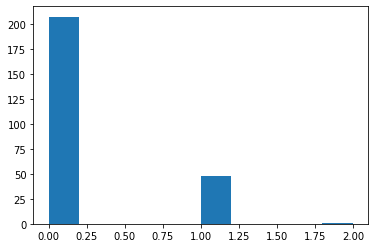

In [23]:
plt.hist(test_y)
plt.show()
plt.hist(predicted)
plt.show()

## 데이터 자체의 분포?

![image histogram equalization](https://t1.daumcdn.net/cfile/tistory/99B424365CF2277C10)

In [25]:
batch_train_x, batch_train_y = next(iter(train_data_generator))
print(batch_train_x.shape)
print(batch_train_y.shape)

(256, 224, 224, 3)
(256,)


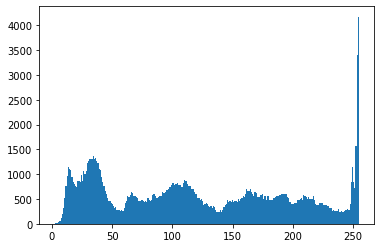

In [28]:
batch_train_x, batch_train_y = next(iter(train_data_generator))
plt.hist(batch_train_x[0].flatten(), bins=256)
plt.show()

## 사전 학습 데이터 차이?

전이학습에 사용된 EfficientNetB2는 ImageNet 데이터로 학습된 것이다. 그런데 지금 대상 데이터는 망막 데이터로 ImageNet과 그 특성이 많이 다르다. 가져온 conv layer들도 학습이 되도록 한다.

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 7, 7, 1408)        7768569   
_________________________________________________________________
flatten_15 (Flatten)         (None, 68992)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                2207776   
_________________________________________________________________
batch_normalization_15 (Batc (None, 32)                128       
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 99        
Total params: 9,976,572
Trainable params: 9,908,933
Non-trainable params: 67,639
_________________________________________________________________
Found 1234 images belonging to 3 classes.
Found 310 images belonging to 3 classes.
Epoch 1/10
19/19 [===

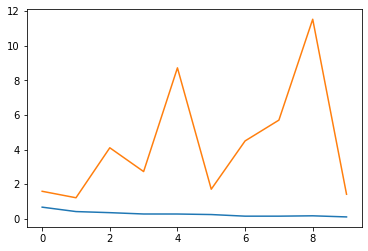

4/4 [==============================] - 1s 233ms/step - loss: 1.4247 - acc: 0.7129
loss= 1.4246889352798462
acc= 0.7129032015800476


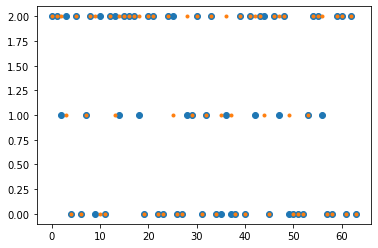

label category index = 2.0
predicted category index = 2
predicted category name = normal


In [31]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# conv_layers.trainable = False
conv_layers.trainable = True   # <-----------------------------------


  
model = models.Sequential()

model.add(conv_layers)
model.add(Flatten())
# model.add(Dense(256, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

# BATCH_SIZE = 64
BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "data/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "data/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/BATCH_SIZE,  
      validation_steps=test_data_generator.samples/BATCH_SIZE,      
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/BATCH_SIZE
)
print("loss=", loss)
print("acc=", acc)



test_x, test_y = next(iter(test_data_generator))
y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", test_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


최소한 val_acc가 0.5가 넘는 경우가 보인다. 약간의 희망이 보인다.